# Tenor saxophone SVM analysis

* Sample duration = 5s
* model = SVM
* target = TENOR

Distinguish between samples with tenor saxophone from those without tenor saxophone. Other brass and reed instruments excluded.

Gather statistics, plot precision-recall and ROC curves.

In [22]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [2]:
df = pd.read_pickle('./data/5s/labeled/features_r02/all_data.pkl')

In [3]:
fn = './scikit_models/tenor_svm_bagging_tuned_c.pkl'  # This is the saved model.
with open(fn, 'rb') as fh:
    model = pickle.load(fh)

In [4]:
NUM_LABEL_COLS = 13
NUM_COMPONENTS = 44
TEST_SIZE = 0.2
RANDOM_SEED = 0

In [5]:
df_filtered = df
df_filtered.shape

(9080, 10790)

In [6]:
# exclude records we want to exclude
df_filtered = df_filtered[df_filtered['alto'] == '0'] 
df_filtered = df_filtered[df_filtered['sop'] == '0']
df_filtered = df_filtered[df_filtered['bari'] == '0']
df_filtered = df_filtered[df_filtered['clrt'] == '0']
df_filtered = df_filtered[df_filtered['tora'] == '0']
df_filtered = df_filtered[df_filtered['othr'] == '0']
df_filtered = df_filtered[df_filtered['trmp'] == '0']
df_filtered = df_filtered[df_filtered['trmb'] == '0']
df_filtered = df_filtered[df_filtered['otrb'] == '0']

num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS 
data = df_filtered.iloc[:, 1:num_x_cols].to_numpy() 
# ^ These are the features
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

target = df_filtered[['tenr']].to_numpy().ravel()  # << This is the label

print(data.shape)
print(target.shape)

(6434, 10776)
(6434,)


In [7]:
pca = PCA(n_components=NUM_COMPONENTS)

In [8]:
pca.fit(data)

PCA(n_components=44)

In [9]:
d = pca.transform(data)

In [10]:
x_train, x_test, y_train, y_test = \
     train_test_split(d, target, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [11]:
fn = 'scikit_models/tenor_svm_bagging_tuned_c.pkl'
with open(fn, 'rb') as fh:
    model = pickle.load(fh)

In [12]:
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))

0.891996891996892


In [13]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,525,72
1,67,623


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       597
           1       0.90      0.90      0.90       690

    accuracy                           0.89      1287
   macro avg       0.89      0.89      0.89      1287
weighted avg       0.89      0.89      0.89      1287



In [15]:
probas_pred = model.predict_proba(x_test)

In [16]:
y_pred_pos = probas_pred[:, [1]]

In [17]:
y_true = [1 if x == '1' else 0 for x in y_test]

In [18]:
precision, recall, threshold = precision_recall_curve(y_true, y_pred_pos)

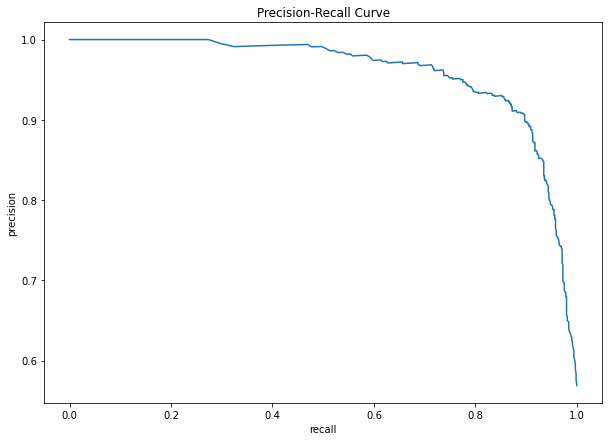

In [19]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-Recall Curve")
pass

In [20]:
fpr, tpr, threshold = roc_curve(y_true, y_pred_pos)
auc = roc_auc_score(y_true, y_pred_pos)

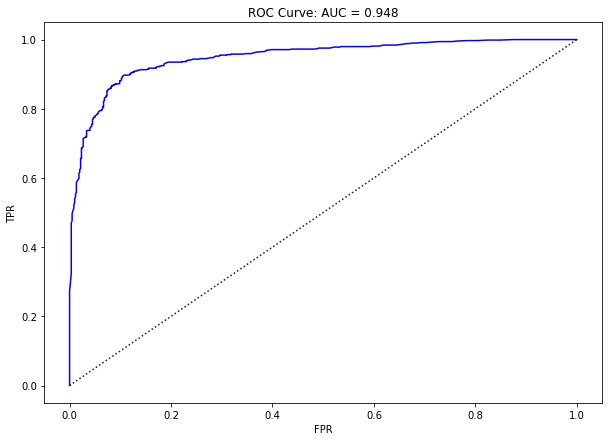

In [21]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], ':', color='0.1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve: AUC = {:.3f}".format(auc)) 
pass